# MLflow Logging

## Setup

For this tutorial we will simplify the approach by using MLflow's local client. One of MLflow's advantages is that it uses the exact same API to work both locally and in the cloud. So with a minor setup, the code shown here can be easily extended if you're working with MLflow in Kubernetes or in Databricks, for example. In order to get started, make sure you have both `mlflow` and `whylogs` installed in your environment by uncommenting the following cells:

In [ ]:
# Note: you may need to restart the kernel to use updated packages.
!pip3 install --proxy http://hpeproxy.its.hpecorp.net:443/ 'whylogs[viz]'

We are also installing `pandas`, `scikit-learn` and `matplotlib` in order to have a very simple training example and show you how you can start profiling your training data with `whylogs`. So, if you still haven't, also run the following cell:

In [ ]:
!pip3 install --proxy http://hpeproxy.its.hpecorp.net:443/ graphviz scikit-learn matplotlib pandas mlflow-skinny

In [ ]:
!pip3 install --proxy http://hpeproxy.its.hpecorp.net:443/ pydotplus

## Get the data

Now let us get an example dataset from the `scikit-learn` library and create a function that returns an aggregated dataframe with it. We will use this same function later on!

In [1]:
import pandas as pd
from sklearn.datasets import load_iris

def get_data() -> pd.DataFrame:
    iris_data = load_iris()
    dataframe = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
    dataframe["target"] = pd.DataFrame(iris_data.target)
    return dataframe

In [2]:
df = get_data()

In [3]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Train a model

Let's define the simplest model to be trained with `scikit-learn`. We aren't interested in model performance nor deep ML concepts, but only in having some baseline model being trained and having the overall idea of how to use `whylogs` with your existing training pipeline.

In [4]:
from sklearn.tree import DecisionTreeClassifier

def train(dataframe: pd.DataFrame) -> None:
    model = DecisionTreeClassifier(max_depth=2)
    model.fit(dataframe.drop("target", axis=1), y=dataframe["target"])

In [5]:
import os
from urllib.parse import urlparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, datetime
import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifact
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.inspection import permutation_importance
from mlflow.models.signature import infer_signature
from sklearn import tree

from pydotplus import graph_from_dot_data
import graphviz
from IPython.display import Image

import itertools, os

plt.style.use("fivethirtyeight")
pd.plotting.register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

if os.path.exists("model_artifacts"):
    os.system("rm -rf model_artifacts")
os.mkdir("model_artifacts")

We could serialize a model, but we will take a shortcut here taking advantage of `mlflow`'s awesome `autolog` method.

In [6]:
experiment_name = 'whylogs-mlflow01'
mlflow.set_experiment(experiment_name)

with mlflow.start_run() as run:
    mlflow.sklearn.autolog()

    df = get_data()
    train(dataframe=df)

    run_id = run.info.run_id

    mlflow.end_run()

2023/09/27 11:35:22 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmps6kk8phx/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


## Profile the training data with `whylogs`

Now in order to profile your training data with `whylogs`, you'll basically need to use our `logger` API, which is as simple as:

In [7]:
import whylogs as why

profile_result = why.log(df)
profile_view = profile_result.view()

⚠️ No session found. Call whylogs.init() to initialize a session and authenticate. See https://docs.whylabs.ai/docs/whylabs-whylogs-init for more information.


In [8]:
profile_view.to_pandas()

,cardinality/est,cardinality/lower_1,cardinality/upper_1,counts/inf,counts/n,counts/nan,counts/null,distribution/max,distribution/mean,distribution/median,...,type,types/boolean,types/fractional,types/integral,types/object,types/string,types/tensor,frequent_items/frequent_strings,ints/max,ints/min
column,,,,,,,,,,,,,,,,,,,,,
petal length (cm),43.000004,43.0,43.002151,0,150,0,0,6.9,3.758000,4.4,...,SummaryType.COLUMN,0,150,0,0,0,0,NaN,NaN,NaN
petal width (cm),22.000001,22.0,22.001100,0,150,0,0,2.5,1.199333,1.3,...,SummaryType.COLUMN,0,150,0,0,0,0,NaN,NaN,NaN
sepal length (cm),35.000003,35.0,35.001750,0,150,0,0,7.9,5.843333,5.8,...,SummaryType.COLUMN,0,150,0,0,0,0,NaN,NaN,NaN
sepal width (cm),23.000001,23.0,23.001150,0,150,0,0,4.4,3.057333,3.0,...,SummaryType.COLUMN,0,150,0,0,0,0,NaN,NaN,NaN
target,3.000000,3.0,3.000150,0,150,0,0,2.0,1.000000,1.0,...,SummaryType.COLUMN,0,0,150,0,0,0,"[FrequentItem(value='1', est=50, upper=50, low...",2.0,0.0


## Writing your profile to `mlflow`

Now even more interesting than writing this profile locally is the ability to use `mlflow`'s API **together** with `whylogs`', in order to store the training data profile and analyze the results of your experiments over time. For that, we basically need to define a function that will

1. Profile our training data
2. Log the profile as an `mlflow` artifact

Let's see how this function can be written:

In [9]:
def log_profile(dataframe: pd.DataFrame) -> None:
    profile_result = why.log(dataframe)
    profile_result.writer("mlflow").write()

And we can call that function we defined in our `mlflow` run experiment, like this:

In [10]:
with mlflow.start_run() as run:
    mlflow.sklearn.autolog()

    df = get_data()
    train(dataframe=df)

    log_profile(dataframe=df)

    run_id = run.info.run_id

    mlflow.end_run()

2023/09/27 11:37:28 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp2uqvht97/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


And we can even use `mlflow`'s API to fetch and read back our profile, like:

In [11]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

local_dir = "/mnt/shared/artifact_downloads"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)
local_path = client.download_artifacts(run_id, "whylogs", local_dir)

In [12]:
os.listdir(local_path)

['profile_2023-09-27 11:10:59.954347+00:00.bin',
 'profile_2023-09-27 11:37:29.415083+00:00.bin',
 'profile_2023-09-25 07:11:31.666995+00:00.bin']

In [13]:
profile_name = os.listdir(local_path)[0]
result = why.read(path=f"{local_path}/{profile_name}")

In [14]:
result.view().to_pandas()

,cardinality/est,cardinality/lower_1,cardinality/upper_1,counts/inf,counts/n,counts/nan,counts/null,distribution/max,distribution/mean,distribution/median,...,type,types/boolean,types/fractional,types/integral,types/object,types/string,types/tensor,frequent_items/frequent_strings,ints/max,ints/min
column,,,,,,,,,,,,,,,,,,,,,
petal length (cm),43.000004,43.0,43.002151,0,150,0,0,6.9,3.758000,4.4,...,SummaryType.COLUMN,0,150,0,0,0,0,NaN,NaN,NaN
petal width (cm),22.000001,22.0,22.001100,0,150,0,0,2.5,1.199333,1.3,...,SummaryType.COLUMN,0,150,0,0,0,0,NaN,NaN,NaN
sepal length (cm),35.000003,35.0,35.001750,0,150,0,0,7.9,5.843333,5.8,...,SummaryType.COLUMN,0,150,0,0,0,0,NaN,NaN,NaN
sepal width (cm),23.000001,23.0,23.001150,0,150,0,0,4.4,3.057333,3.0,...,SummaryType.COLUMN,0,150,0,0,0,0,NaN,NaN,NaN
target,3.000000,3.0,3.000150,0,150,0,0,2.0,1.000000,1.0,...,SummaryType.COLUMN,0,0,150,0,0,0,"[FrequentItem(value='1', est=50, upper=50, low...",2.0,0.0


And with those few lines we have successfully fetched the profile artifact from our experiment. Over time, we will be able to track down some very relevant information on how our data behaves, **why** is our model generating the results and walk towards a more Robust and Responsible AI field.
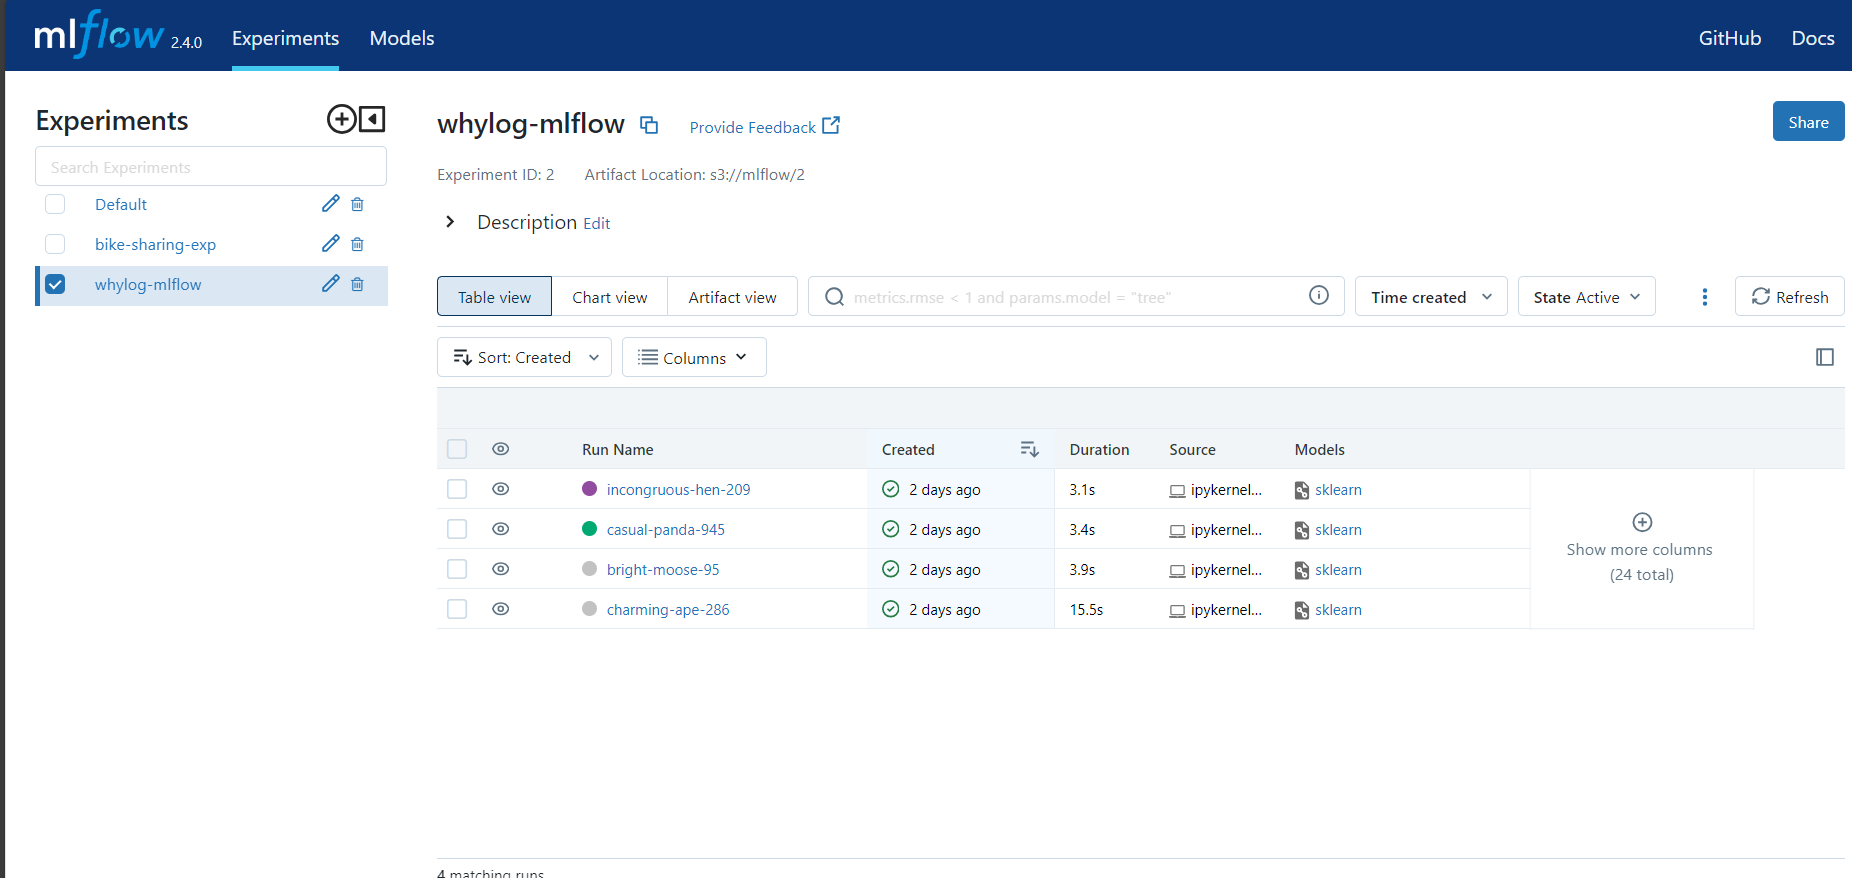
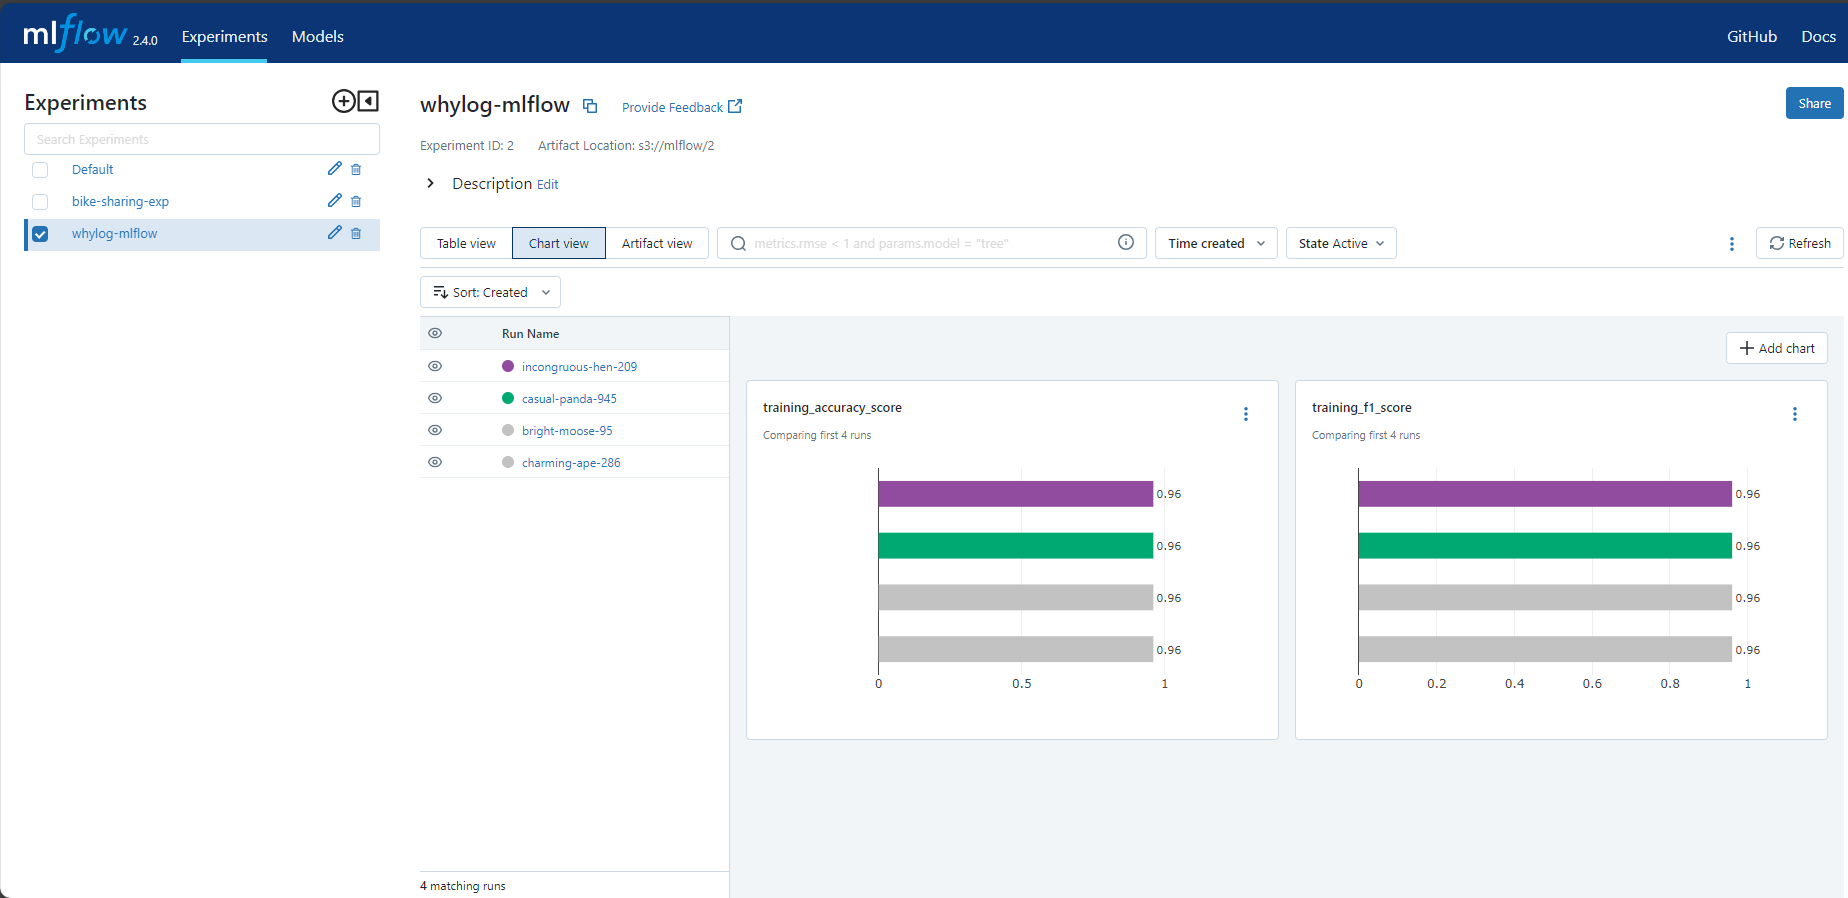